In [1]:
import numpy as np

# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/BLA_LFP_data/LFP_BLA_gamma.mat'  # True In Vivo Data
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_background.mat'  # Pink Noise/Background
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_bg_like_sig.mat'  # Buried Gamma in BG
INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/Generated/pn_multisine_gamma.npz'  # Generated Sine in PN

In [2]:
from lfp_prediction.data_gathering import MatlabCollector, NumpyCollector

frequency_band = (55, 85)

if 'dc' in locals():  # This is done to delete the massive variables and free up some space before attempting to use more
    del dc
    del data
    del labels
dc = NumpyCollector(INVIVO_RAW_PATH)
dc.get_data()
data, labels = dc.filter_data(filter_type='non-causal',
                              freq_band=frequency_band,
                              filter_rate=400)

2468
(5242, 1, 300)
(5242, 1, 300)


(5242, 1, 300)


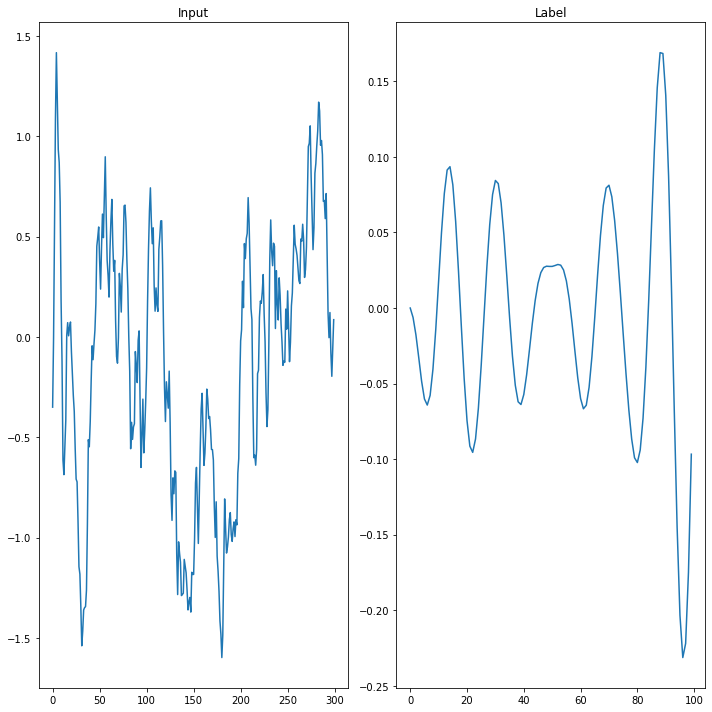

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from lfp_prediction.config import params

print(data.shape)

fig = plt.figure(figsize=(10,10))
gs = GridSpec(1,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

ax1.plot(np.arange(0,params.PREVIOUS_TIME,1), data[0,0,0:params.PREVIOUS_TIME])
ax1.set_title('Input')

# ax2.plot(np.arange(params.PREVIOUS_TIME, params.PREVIOUS_TIME+params.LOOK_AHEAD, 1), labels[0,0,:])
ax2.plot(np.arange(0,100,1), labels[0,0,0:100])
ax2.set_title('Label')

plt.tight_layout()
plt.show()

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

split_idx = int(.75 * data.shape[0])

print(split_idx)
print(data.shape)
print(labels.shape)

train_data = DataLoader(TensorDataset(torch.Tensor(data[:split_idx, :, :]), torch.Tensor(labels[:split_idx, :, :])), batch_size=batch_size, shuffle=True)
valid_data = DataLoader(TensorDataset(torch.Tensor(data[split_idx:, :, :]), torch.Tensor(labels[split_idx:, :, :])), batch_size=batch_size, shuffle=False)

3931
(5242, 1, 300)
(5242, 1, 300)


In [5]:
import torch.nn as nn
from torch.fft import rfft
from scipy import stats, signal
from typing import Tuple, List, Optional

def get_norm_factor(full_lfp: np.ndarray) -> np.ndarray:
    norm_factor = []
    for i in range(full_lfp.shape[0]):
        lfp = np.squeeze(full_lfp[i,:,:].T)
        nfft = 2**7 # 128 samples
        f, Pxx = signal.welch(lfp, fs=1000, window='hamming', nperseg=nfft, scaling='spectrum')
        f = f.ravel()

        f_cutoff = max(np.argmax(Pxx),1)
        Pmax = Pxx[f_cutoff]
        idx = np.arange(f_cutoff,f.size)
        result = stats.linregress(np.log(f[idx]),np.log(Pxx[idx]))
        b = result.intercept
        a = -result.slope

        f_cutoff = np.exp((b-np.log(Pmax))/a)
        idx = f>f_cutoff
        Pfit = Pxx.copy()
        Pfit[idx] = np.exp(b)/f[idx]**a
        Pfit[~idx] = Pmax
        norm_factor.append(np.square(Pmax/Pfit))
    norm_factor = np.stack(norm_factor)
    return norm_factor

def fft_loss(output: torch.Tensor, target: torch.Tensor, norm_factor: Optional[torch.Tensor] = None) -> torch.Tensor:
    fft_data = (rfft(output, n=128).real - rfft(target, n=128).real)
    # print(norm_factor.shape)
    # print(fft_data.shape)
    sampled_loss = torch.sum(torch.square(torch.multiply(norm_factor, fft_data)), axis=1)
    # print(multiplied.shape)
    # loss = torch.sum(fft_data)
    loss = torch.sum(sampled_loss)
    # print(loss.shape)
    return loss

In [6]:
import copy
from lfp_prediction.models import FCN, CNN, LSTM, fit

epochs = 50

# model = CNN(in_size=2048, h_size=500, out_size=10)
model = FCN(in_size=300, h_size=400, out_size=300)
# model = LSTM(in_size=1, h_size=50, out_size=100)
# model.load_state_dict(torch.load('LSTM_syn_gammawithbg_nc.pth'))
model_initial = copy.deepcopy(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
t_loss, v_loss = fit(model, train_data, valid_data, epochs, device)

100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


In [7]:
look_back = 0
def validate_model(model: nn.Module,
                   validation_loader: torch.utils.data.DataLoader,
                   device: torch.device) -> Tuple[List[float], List[float]]:
    losses = {i:0 for i in range(-look_back, params.LOOK_AHEAD, 1)}
    for i, (x, y) in enumerate(validation_loader):
        x = x.to(device)
        output = model(x)
        output = output.to("cpu").detach().numpy()
        y = y.to("cpu").detach().numpy()
        for t in range(0, params.LOOK_AHEAD + look_back, 1):
            y_true = y[:,:,t]
            y_pred = output[:,:,t]
            squared_error = ((y_true - y_pred) ** 2 / len(y_true))/batch_size
            # print(squared_error.shape)
            losses[t-look_back] += np.sum(squared_error)
    losses = {k: v/len(validation_loader) for k, v in losses.items()}
    return losses


losses = validate_model(model, valid_data, device)
print(losses)

{0: 2.455851654286512e-08, 1: 3.041994333395129e-08, 2: 2.5112269848405713e-07, 3: 6.760227090747254e-07, 4: 1.2034268895437956e-06, 5: 1.1939311063054823e-06, 6: 5.989868482840126e-07, 7: 5.702370785863101e-08, 8: 6.394976978532302e-07, 9: 2.4355357620551352e-06, 10: 4.718394282507489e-06, 11: 5.753384118911416e-06, 12: 4.709247549748753e-06, 13: 2.0855278618422213e-06, 14: 1.6842736930889591e-07, 15: 8.353803487008873e-07, 16: 3.78145967638042e-06, 17: 6.83116881989962e-06, 18: 7.76144953506002e-06, 19: 5.857411507327569e-06, 20: 2.579070954242325e-06, 21: 3.279973717886472e-07, 22: 4.316480425775187e-07, 23: 2.3100876660464564e-06, 24: 4.006340110741226e-06, 25: 4.122288590046881e-06, 26: 2.8249465940905615e-06, 27: 1.203568227238731e-06, 28: 1.5266886586365527e-07, 29: 1.2532500851726004e-07, 30: 3.836744753016319e-07, 31: 3.8021015937807176e-07, 32: 2.7613517153074607e-07, 33: 4.254552244384652e-08, 34: 6.821064931312033e-08, 35: 7.19838072293109e-08, 36: 3.617873606118814e-08, 37

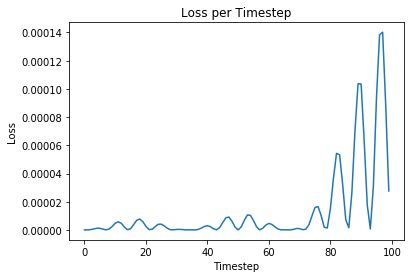

In [8]:
from datetime import datetime
from lfp_prediction.config import paths

now = datetime.now()
savefile = 'Loss_' + now.strftime("%m_%d_%Y_%H_%M_%S") + '.png'

lists = sorted(losses.items())

timestep, loss_val = zip(*lists)
plt.plot(timestep, loss_val)
plt.xlabel('Timestep')
plt.ylabel('Loss')
plt.title('Loss per Timestep')

plt.savefig(paths.IMG_DIR + savefile)
plt.show()

In [9]:
x, y = next(iter(valid_data))
model.eval()
x = x.to(device)
output = model(x)
x = x.to("cpu").detach().numpy()
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

print(x.shape)
print(y.shape)
print(output.shape)

(32, 1, 300)
(32, 1, 300)
(32, 1, 300)


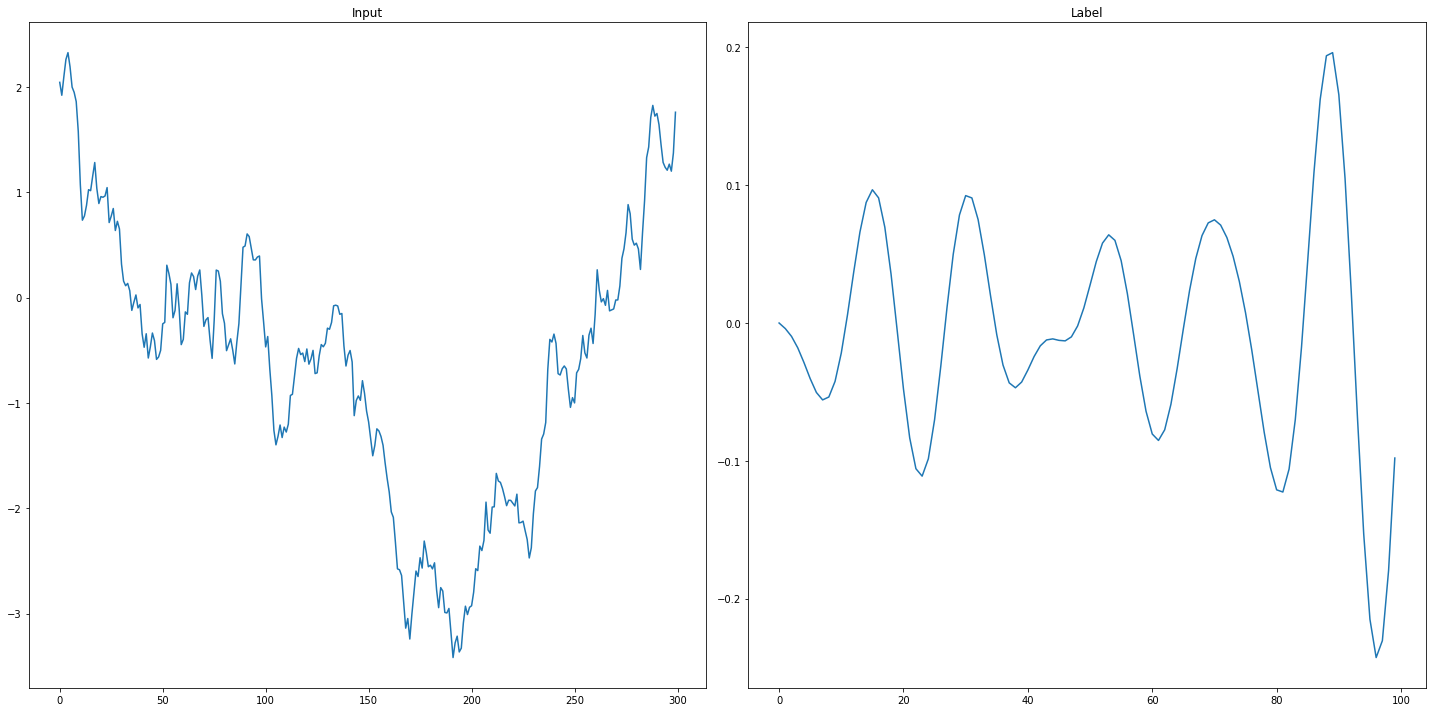

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.plot(np.arange(0,params.PREVIOUS_TIME,1), x[0,0,:params.PREVIOUS_TIME])
ax1.set_title('Input')

# ax2.plot(np.arange(params.PREVIOUS_TIME-look_back, params.PREVIOUS_TIME+params.LOOK_AHEAD, 1), y[0,0,:])
ax2.plot(np.arange(0,100,1), y[0,0,0:100])
ax2.set_title('Label')

plt.tight_layout()
plt.show()

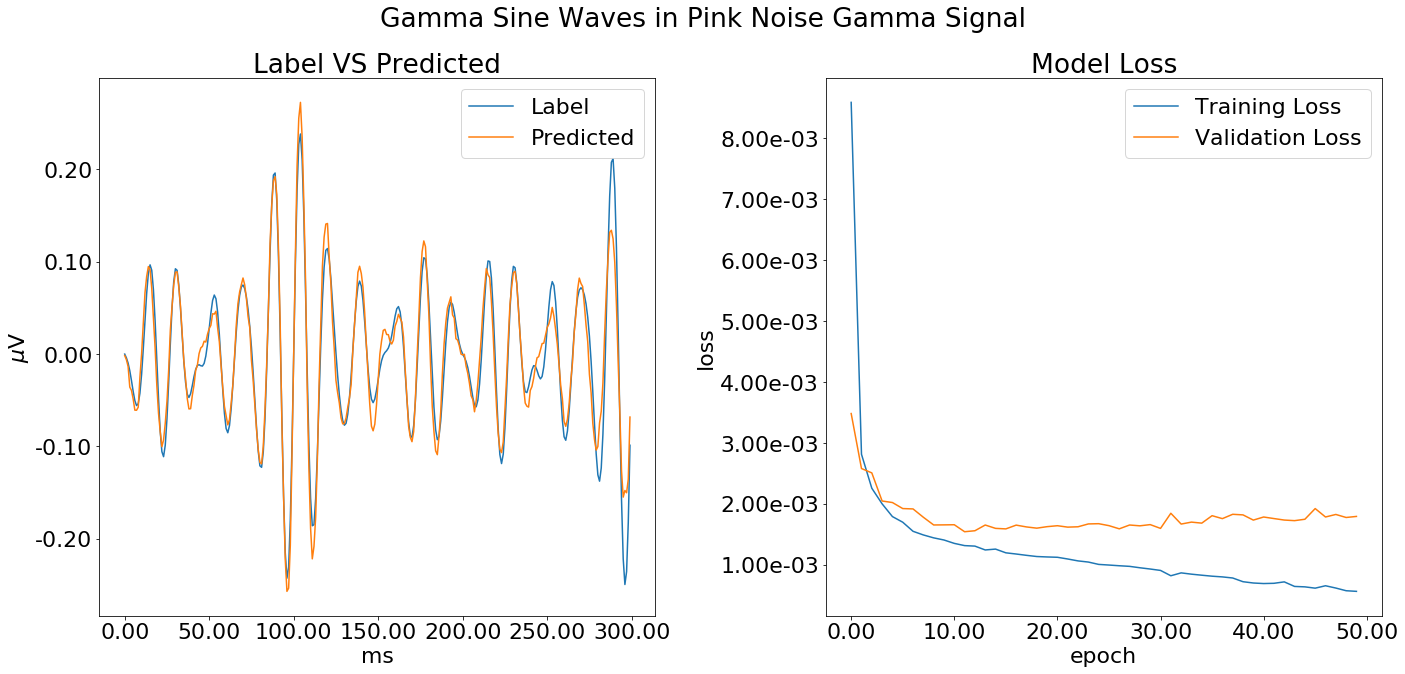

In [12]:
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

scaled_t_loss = [l/(split_idx/batch_size) for l in t_loss]
scaled_v_loss = [l/((data.shape[0] - split_idx)/batch_size) for l in v_loss]

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 22

fig = plt.figure(figsize=(20,10))
gs = GridSpec(1,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

fig.suptitle('Gamma Sine Waves in Pink Noise Gamma Signal')

t = np.arange(0, 300)

ax1.plot(t, y[0,0,:], label='Label')
ax1.plot(t, output[0,0,:], label='Predicted')
# ax1.plot([200, 200], ax1.get_ylim(), ':')
ax1.set_xlabel('ms')
ax1.set_ylabel(r'$\mu$V')
ax1.set_title('Label VS Predicted')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.legend(loc='best')

ax2.plot(np.arange(epochs), np.array(scaled_t_loss), label='Training Loss')
ax2.plot(np.arange(epochs), np.array(scaled_v_loss), label='Validation Loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Model Loss')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.legend(loc='best')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

savefile = 'Signal_and_ModelLoss_' + now.strftime("%m_%d_%Y_%H_%M_%S") + '.png'
plt.savefig(paths.IMG_DIR + savefile)
plt.show()